In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
X_train = pickle.load(open('../Data/X_train.pkl', 'rb'))
X_test = pickle.load(open('../Data/X_test.pkl', 'rb'))
y_train = pickle.load(open('../Data/y_train.pkl', 'rb'))
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(329, 20530)
(83, 20530)
(329,)
(83,)


## Keeping 99% variance

In [3]:
from sklearn.decomposition import PCA
import pandas as pd

# Initialize PCA with n_components=0.99
pca = PCA(n_components=0.99)

reduced_X_train = pca.fit_transform(X_train)

selected_components = pca.n_components_
print(f"Number of components selected to explain 99% of variance: {selected_components}")

Number of components selected to explain 99% of variance: 305


In [4]:
reduced_X_test = pca.transform(X_test)

print(reduced_X_train.shape)
print(reduced_X_test.shape)

(329, 305)
(83, 305)


### Exhausive search for finding the best parameters for Random Forest model

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

gs = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)   # cv=3 means 3-fold cross validation
gs.fit(reduced_X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 3, 5, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [6]:
print("Best parameters: ", gs.best_params_)
print("Best Training score: ", gs.best_score_)
print("Test score: ", gs.score(reduced_X_test, y_test))

Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Training score:  0.8541006394217403
Test score:  0.8072289156626506


In [7]:
from sklearn.metrics import roc_auc_score

y_pred_test = gs.best_estimator_.predict(reduced_X_test)
auc_score = roc_auc_score(y_test, y_pred_test)
print("AUC Score:", auc_score)

AUC Score: 0.5


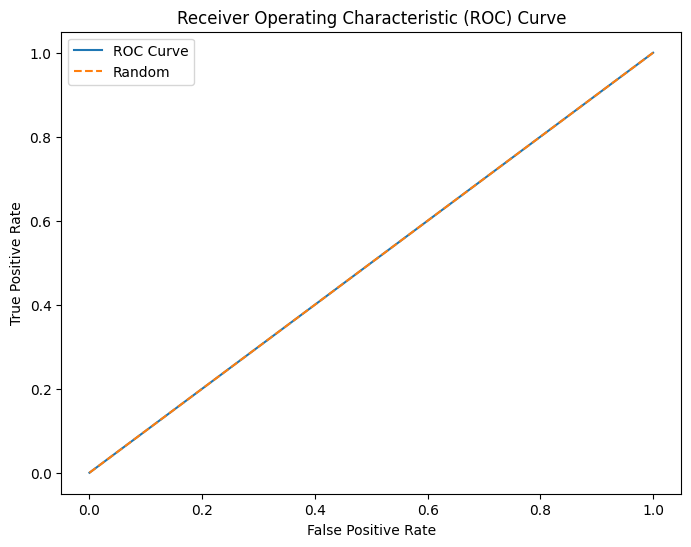

In [8]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Experimenting with the number of components to keep
Now let's experiment with the number of components to find how many components we need to keep to get the best accuracy.

In [12]:
from sklearn.metrics import roc_auc_score

train_accuracy_list = []
test_accuracy_list = []
auc_score_list = []
max_acc = -999
optimal_model = None
optimal_n_components = None
optimal_x_train = None
optimal_x_test = None
optimal_predictions = None

param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    }

# components_list = [50, 100, 150, 200, 250, 300, 320]
components_list = np.arange(10, X_train.shape[0])

for n_components in components_list:
    
    # PCA with n_components
    pca = PCA(n_components=n_components)
    reduced_X_train = pca.fit_transform(X_train)
    reduced_X_test = pca.transform(X_test)

    # Grid Search CV with Random Forest
    rf = RandomForestClassifier(random_state=42)
    gs = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)   # cv=3 means 3-fold cross validation
    gs.fit(reduced_X_train, y_train)
    model = gs.best_estimator_

    # Evaluation
    train_accuracy = gs.best_score_
    test_accuracy = model.score(reduced_X_test, y_test)
    y_pred_test = model.predict(reduced_X_test)
    auc_score = roc_auc_score(y_test, y_pred_test)

    train_accuracy_list.append(train_accuracy)
    test_accuracy_list.append(test_accuracy)
    auc_score_list.append(auc_score)

    # for saving the best model
    if test_accuracy > max_acc:
        max_acc = test_accuracy
        optimal_model = model
        optimal_n_components = n_components
        optimal_x_train = reduced_X_train
        optimal_x_test = reduced_X_test
        optimal_predictions = y_pred_test

    print(f"n_components: {n_components}, Train Set Accuracy:{train_accuracy}, Test Set Accuracy: {test_accuracy}, AUC Score: {auc_score}")
    print()

Fitting 3 folds for each of 108 candidates, totalling 324 fits
n_components: 10, Train Set Accuracy:0.9362246316374757, Test Set Accuracy: 0.9397590361445783, AUC Score: 0.8913246268656716

Fitting 3 folds for each of 108 candidates, totalling 324 fits
n_components: 11, Train Set Accuracy:0.9301362246316375, Test Set Accuracy: 0.927710843373494, AUC Score: 0.8600746268656717

Fitting 3 folds for each of 108 candidates, totalling 324 fits
n_components: 12, Train Set Accuracy:0.9362246316374757, Test Set Accuracy: 0.9397590361445783, AUC Score: 0.8913246268656716

Fitting 3 folds for each of 108 candidates, totalling 324 fits
n_components: 13, Train Set Accuracy:0.9362246316374757, Test Set Accuracy: 0.9156626506024096, AUC Score: 0.8288246268656716

Fitting 3 folds for each of 108 candidates, totalling 324 fits
n_components: 14, Train Set Accuracy:0.9392271337225465, Test Set Accuracy: 0.9156626506024096, AUC Score: 0.8526119402985075

Fitting 3 folds for each of 108 candidates, totalli

KeyboardInterrupt: 

In [15]:
print("Best parameters: ", optimal_model.get_params())
print("Optimal n_components: ", optimal_n_components)
print("Best Test Accuracy: ", max_acc)
print("AUC Score: ", roc_auc_score(y_test, optimal_predictions))

Best parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Optimal n_components:  10
Best Test Accuracy:  0.9397590361445783
AUC Score:  0.8913246268656716


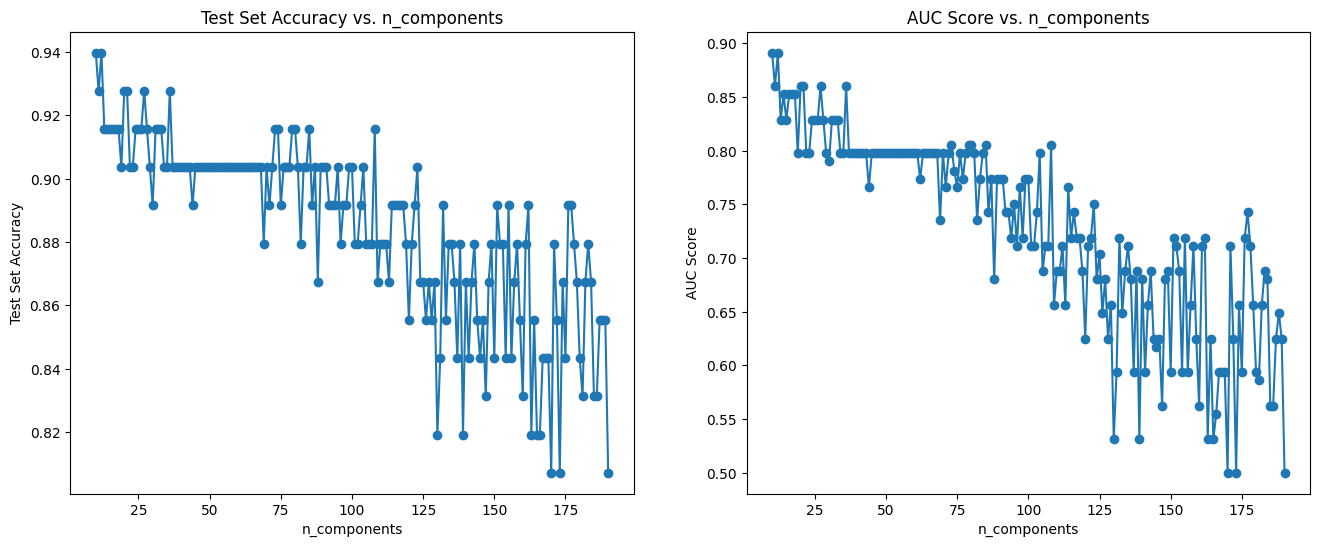

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(np.arange(10, 191), test_accuracy_list, marker='o')
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('Test Set Accuracy')
ax[0].set_title('Test Set Accuracy vs. n_components')

ax[1].plot(np.arange(10, 191), auc_score_list, marker='o')
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('AUC Score')
ax[1].set_title('AUC Score vs. n_components')

plt.show()

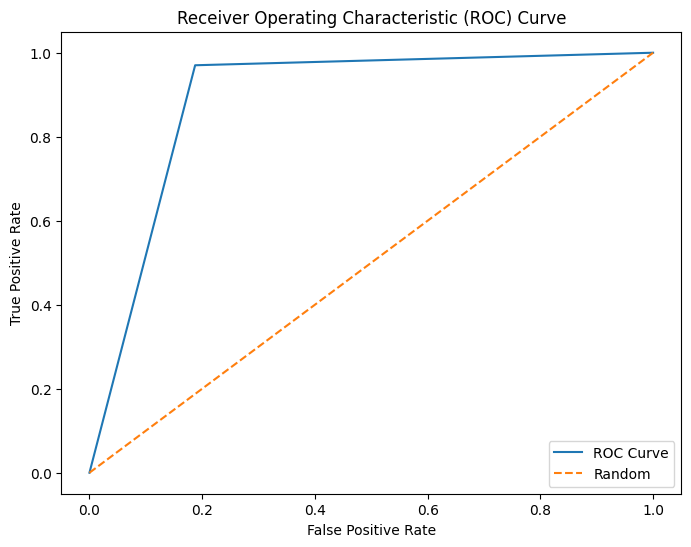

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, optimal_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, optimal_predictions)

array([[13,  3],
       [ 2, 65]], dtype=int64)

In [31]:
# make a df containing n_components, train_accuracy, test_accuracy, auc_score
df = pd.DataFrame({'n_components': range(10, 191), 'train_accuracy': train_accuracy_list, 'test_accuracy': test_accuracy_list, 'auc_score': auc_score_list})
df

,n_components,train_accuracy,test_accuracy,auc_score
0,10,0.936225,0.939759,0.891325
1,11,0.930136,0.927711,0.860075
2,12,0.936225,0.939759,0.891325
3,13,0.936225,0.915663,0.828825
4,14,0.939227,0.915663,0.852612
...,...,...,...,...
176,186,0.881401,0.831325,0.562500
177,187,0.872366,0.855422,0.625000
178,188,0.890520,0.855422,0.648787
179,189,0.884543,0.855422,0.625000


In [33]:
df.to_csv('pca_rf_results.csv', index=False)

In [28]:
import pickle

dict = {
    'Model': optimal_model,
    'n_components': optimal_n_components,
    'x_train': optimal_x_train,
    'x_test': optimal_x_test,
    'predictions': optimal_predictions,
    'Test Accuracy': max_acc,
    'AUC_score': roc_auc_score(y_test, optimal_predictions)
}


with open('RF_PCA.pkl', 'wb') as file:
    pickle.dump(dict, file)

### Load to verify

In [29]:
dct = pickle.load(open('RF_PCA.pkl', 'rb'))
X_test = dct['x_test']
y_test = pickle.load(open('../Data/y_test.pkl', 'rb'))

from sklearn.metrics import accuracy_score, roc_auc_score

y_pred_test = dct['Model'].predict(X_test)
acc_score = accuracy_score(y_test, y_pred_test)
auc_score = roc_auc_score(y_test, y_pred_test)

print("Test Accuracy: ", acc_score)
print("AUC Score: ", auc_score)

Test Accuracy:  0.9397590361445783
AUC Score:  0.8913246268656716
